# Data preparation

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
# impute missing values, if categorical use mode, if numerical use 0
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna('NA', inplace=True)
    else:
        df[col].fillna(0.0, inplace=True)

/var/folders/dz/5wmz844x1q782bmfw947xv2h0000gn/T/ipykernel_49470/3473148539.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('NA', inplace=True)
/var/folders/dz/5wmz844x1q782bmfw947xv2h0000gn/T/ipykernel_49470/3473148539.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [7]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [8]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [9]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% usind train_test_split
from sklearn.model_selection import train_test_split

# Split the data into 80% full train and 20% test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split the full train into 60% train and 20% validation
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 80% = 20%

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# Verify the sizes
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 876
Validation size: 293
Test size: 293


# Question 1

In [10]:
#Which numerical variable (among the following 4) has the highest AUC?
from sklearn.metrics import roc_auc_score

def auc_score(df, feature):
    score = roc_auc_score(y_train, df[feature])
    return score    

numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for feature in numerical:
    print(feature, auc_score(df_train, feature))

lead_score 0.6144993577250176
number_of_courses_viewed 0.7635680590007088
interaction_count 0.738270176293409
annual_income 0.5519578313253012


# Question 2

In [11]:
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Select categorical columns from the training set
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns

categorical = list(categorical_columns)
numerical = list(numerical_columns)

print("Categorical columns:", categorical)
print("Numerical columns:", numerical)

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

dv, model = train(df_train, y_train, C=1.0)

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


y_pred = predict(df_val, dv, model)


Categorical columns: ['lead_source', 'industry', 'employment_status', 'location']
Numerical columns: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [12]:
auc = roc_auc_score(y_val, y_pred)
auc

0.8171316268814112

# Q3    

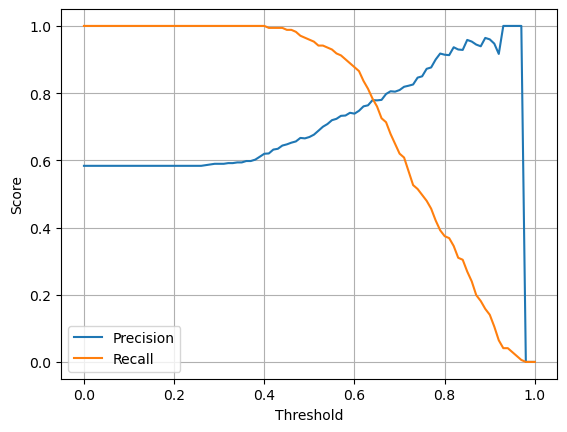

In [13]:
#Now let's compute precision and recall for our model.

#Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
#For each threshold, compute precision and recall
#Plot them
#At which threshold precision and recall curves intersect?

#0.145
#0.345
#0.545
#0.745

import numpy as np
import matplotlib.pyplot as plt
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
for t in thresholds:
    y_pred_label = (y_pred >= t).astype(int)
    tp = ((y_val == 1) & (y_pred_label == 1)).sum()
    fp = ((y_val == 0) & (y_pred_label == 1)).sum()
    fn = ((y_val == 1) & (y_pred_label == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

In [14]:
# Finding intersection point
intersections = []

for i in range(len(precisions) - 1):
    if (precisions[i] - recalls[i] >= 0 and precisions[i+1] - recalls[i+1] < 0) or (precisions[i] - recalls[i] < 0 and precisions[i+1] - recalls[i+1] >= 0):
        intersections.append(thresholds[i])

# Print the intersection points
print(f"Intersection points: {intersections}")

Intersection points: [np.float64(0.64)]


# Q4

In [15]:
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
f1_scores = []
for t in thresholds:
    y_pred_label = (y_pred >= t).astype(int)
    tp = ((y_val == 1) & (y_pred_label == 1)).sum()
    fp = ((y_val == 0) & (y_pred_label == 1)).sum()
    fn = ((y_val == 1) & (y_pred_label == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)
# Find the threshold that gives the maximum F1 score
max_f1 = max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1)]
print(f"Best threshold: {best_threshold}, Max F1 score: {max_f1}")


Best threshold: 0.5700000000000001, Max F1 score: 0.8124999999999999


# Q5

In [16]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [17]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1)   
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

print(f"AUC Scores for each fold: {auc_scores}")
print(f"Mean AUC Score: {sum(auc_scores) / len(auc_scores):.3f}")

AUC Scores for each fold: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean AUC Score: 0.822


In [18]:
# Calculate and print the standard deviation of the AUC scores
std_dev_auc = np.std(auc_scores)
print(f"AUC Scores for each fold: {auc_scores}")
print(f"Mean AUC Score: {np.mean(auc_scores):.3f}")
print(f"Standard Deviation of AUC Scores: {std_dev_auc:.3f}")

AUC Scores for each fold: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean AUC Score: 0.822
Standard Deviation of AUC Scores: 0.036


In [19]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.4f +- %.4f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.5602 +- 0.0238
C=0.001 0.8669 +- 0.0287
C=1 0.8221 +- 0.0358
